
Bad key animation.mencoder_args in file /Users/jzinn/.config/matplotlib/stylelib/jcz_paper_latex.mplstyle, line 485 ('animation.mencoder_args:          # Additional arguments to pass to mencoder')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution
/Users/jzinn/envs/anaconda/envs/py38/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)
<ipython-input-2-8709d154b55a>:80: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(soln.t, np.sin(soln.t)/soln.t, linestyle='dashed', label='analytic') # the analytic solution for n = 1


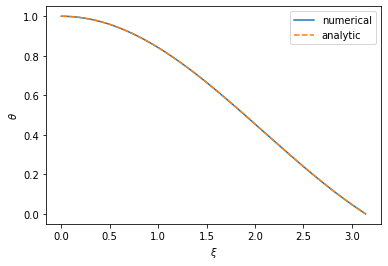

value of theta at x = 0: 1.0
value of theta at x = pi: -7.489126506443622e-17
x at which theta = 0: 3.141592653590708


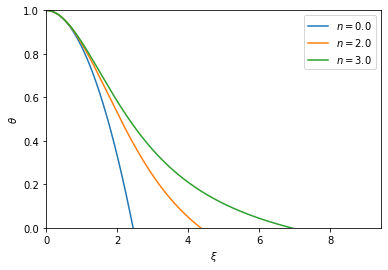

theta at x = 1: 0.8550575685886259


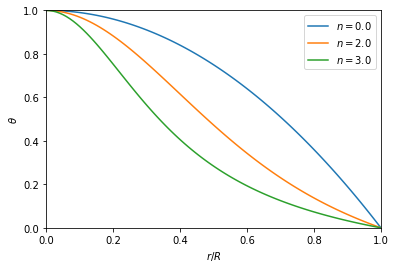

/Users/jzinn/envs/anaconda/envs/py38/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


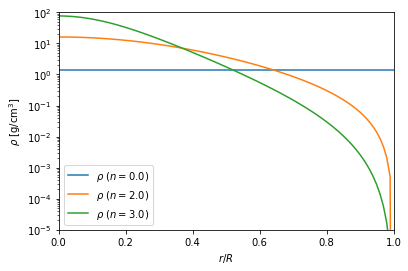

<ipython-input-2-ef732f22c7bb>:106: RuntimeWarning: invalid value encountered in sqrt
  return self.theta(x)**self.n*self.rhocen(M, R)
<ipython-input-2-ef732f22c7bb>:125: RuntimeWarning: invalid value encountered in power
  return self.K(M, R)*self.rho0(x, M, R)**(1.+1./self.n)


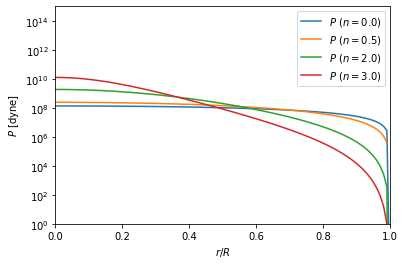

In [2]:
# Will solve for the adiabatic radial amplitude eigenfunction, zeta = (delta x)/x for the case of a polytrope.
# will need polytropes...
%run lane_emden_soln.ipynb import Poly2

In [1]:
import pandas as pd # will use this to read in Schwarzschild's solution

class Poly3(Poly2):
    '''
    A new and improved version of the Poly2 class, which has the same attributes and methods, plus:
    thetaprime(x): the derivative of theta w.r.t. the re-scaled radius, x.
    Gamma0(x): the assumed adiabatic index, Gamma_1, as a function of re-scaled radius, x

    '''
    def __init__(self, n=np.nan):
        super(Poly3, self).__init__(n=n)
        self._thetaprime = interpolate.UnivariateSpline(self.soln.t, self.soln.y[1,:], k=3, s=0, ext=3) # this is the derivative of theta

    def thetaprime(self, x):
        '''
        The derivative of theta w.r.t. the re-scaled radius, x.
        Inputs
        x : float | ndarray
         the re-scaled radius
        Outputs
        thetaprime: float | ndarray
         the derivative w.r.t x of theta at point(s) x
        '''
        return self._thetaprime(x)
    
    def Gamma0(self, x):
        '''
        The assumed adiabatic index, Gamma_1, as a function of re-scaled radius
        Inputs
        x : ndarray or float
        Outputs
         Gamma_1, the adiabatic index. assumed to be constant at every radius.
         schw is the Schwarzchild value and monatomic is for a monatomic ideal gas
        '''
        monatomic = 5./3.
        a = 0.4
        schw = 4./(-a+3) # for a = 0.4
        #return monatomic
        return schw
        

# Because the ODE solver will make multiple calls to iududx, u, and Gamma0, you will want to 
# fix the polytrope equilibrium structure at the beginning and solve it for n once, now.

# We will investigate the n = 3 case and compare to Schwarzschild's solution.
P = Poly3(n=3)

# Note that the solution doesn't care what the mass or radius of the star is.
def iududx(x):
    '''
    1/u du/dx from Schwarzschild 1941
    
    Inputs
    x : ndarray
     the re-scaled radius
     
    Outputs:
    iududx : ndarray
    '''
    return P.thetaprime(x)/P.theta(x)

def u(x):
    '''
    u from Schwarzschild 1941
    
    Inputs
    x : ndarray
     the re-scaled radius
     
    Outputs:
    u : ndarray
     polytropic solution in Schwarzschild notation (AKA theta)
    '''
    return P.theta(x)

# this is the angular frequency of oscillation for the radial oscillation for n = 3, a = 0.4, as computed by Schwarzschild 1941.
omega = np.sqrt(0.10391)

def rhs(x, y):
    '''
    Returns the RHS of dY/dx = A x Y (i.e., the derivative w.r.t. x of Y)

    Inputs
    x : ndarray
     the independent variable (re-scaled radius)
    y : two-element list/ndarray
     the dependent variable, Y (zeta and its derivative)
     
    Outputs
    z : two-element list/ndarray
     the derivative of Y, dY/dx   
    '''
    # Exercise 0.
    # By making reference to the polytrope solution and Schwarzschild's radial oscillation equation
    # for a polytrope, write expressions for z[0] and z[1].

    # z is the derivative of Y w.r.t. x:
    z = [0,0]
    
    z[0] = np.nan
    
    # there is a singularity at 0 so need to explicitly set the derivative of Y to be 0.
    if x < 1e-10:
        return np.inf
    else:
        z[1] = np.nan
    return z

x = np.linspace(1e-10, P.Rx) # this is the re-scaled radius array, going from 0 to the outer radius.
# This file has the radial displacement computed for a n = 3 polytrope with adiabatic index of 4./(-0.4+3) (close but not quite 5/3) for an angular frequency
# corresponding to omega^2 = 0.10391.
# The first column ('x') is the re-scaled radius and the second column ('r') is the radial displacement as a function of x, (delta x)/x.
dat = pd.read_csv('../data/schwarzschild1941.dat', sep=',') # make sure this directory (data) and file (schwarzschild1941.dat) exist in your working directory
# this will interpolate the radial displacement. the way to evaluate the radial displacement is by doing interpdat(x), where x is either a float or ndarray.
interpdat = interpolate.UnivariateSpline(dat['x'], dat['r'], k=1, s=0, ext=3)
# the derivative of the displacement can also be calculated by calling the derivative method, e.g.: interpdat.derivative()(x).
plt.plot(x, interpdat.derivative()(x), label=r'Schwarzschild 1941 $\frac{d \zeta}{dx}$')
plt.plot(dat['x'], dat['r'], label=r"Schwarzschild 1941 $\zeta$")
plt.xlabel(r'$\xi$')

# Exercise 1.
# Use the values of the Schwarzschild solution at x = 0 to as initial conditions to solve for the radial displacement by integrating the radial pulsation equation from the inside of the star to the outside
# Compare the resulting radial displacement function to the Schwarzschild solution by plotting the solutions on top of each other.
# Also compare the derivative of the displacement to the computed solution for the derivative.

y0 = [interpdat(0), interpdat.derivative()(0)]

plt.ylim([0, 1.0])
plt.xlim([0, P.Rx])
plt.plot(np.nan, np.nan, label=r'$\mathrm{computed\ }\zeta$', linestyle='dashed')
plt.plot(np.nan, np.nan, label=r'$\mathrm{computed\ } $\frac{d \zeta}{dx}$', linestyle='dashed')

plt.legend(loc='upper left')
plt.show()

/Users/jzinn/envs/anaconda/envs/py38/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


NameError: name 'Poly2' is not defined

GYRE is a pulsation code that solves the pulsation equations (we have been looking at the radial pulsation equation, but there are others to describe pulsations that occur in 3D and not just 1D).

GYRE needs to know the equilibrium solutions to compute the eigenfunctions and eigenfrequencies; we will use the MESA models that you have run for the Sun.

First, make a new directory to store your GYRE files:

>>> cd ~/Desktop/work/

>>> rsync -avz ~/Desktop/notebooks/astr534/gyre_files ./

gyre_files/run_gyre.sh is the script that will run GYRE. You will need to make it so you can execute it:

>>> chmod +x gyre_files/run_gyre.sh

To run GYRE on the Sun model:

>>> cd 1msun

>>> cp ../gyre_files/gyre.in.temp ./

>>> ../gyre_files/run_gyre.sh LOGS_to_sun/profile6 1 1 1 ./

This will create a sequence of files that have the format *mode-####.h5. Each of these files corresponds to one eigenfunction/eigenfrequency solution to the radial pulsation equation. These mode files have useful information in them:
xi_r: the radial perturbation, delta r
x: the radial coordinate, r/R
lag_P: the Lagrangian pressure perturbation
and much more!


In [4]:
# Let's take a look at the radial perturbation eigenfunction corresponding to the fundamental mode (the mode with the lowest omega^2) for the Sun at present day

from fileio import read_gyre # this will read in GYRE files
profile='LOGS_to_sun/profile6' # this is the MESA model corresponding to the Sun at present day.
n=1 # n = 1 will give us the fundamental mode
ad='ad' # this says that GYRE has been run using the adiabatic versions of the pulsation equations
meta_mode, mode = read_gyre(profile + '.data.GYRE.gyre_'+ad+'.mode-{:05d}.h5'.format(n)) # mode will now have columns like xi_r, lag_P, etc.
# (you can look at all the columns that it has by print(mode.keys())

plt.clf()
plt.plot(mode['x'], mode['xi_r']/mode['x'])
plt.xlabel(r'$r/R$')
plt.ylabel(r'$\mathrm{GYRE\ }\zeta$')
#plt.yscale('symlog') # this may be a useful plotting option. It makes a linear plot from -1 to 1 but logarithmic beyond that so that can plot the origin
# at the same time as making most of the range log-scaled.

# Exercise 2.
# Compare this solution to the polytrope solution from above by plotting them on top of each other.
# Compare this GYRE solution to the GYRE solutions for increasingly larger n. What do you notice about the eigenfunctions?


Bad key animation.mencoder_args in file /Users/jzinn/.config/matplotlib/stylelib/jcz_paper_latex.mplstyle, line 485 ('animation.mencoder_args:          # Additional arguments to pass to mencoder')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/jzinn/zinn/astr534/s24/1msun/LOGS/profile6.data.GYRE.gyre_ad.mode-00001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)